In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import audioflux as af
from scipy.io import wavfile
import sounddevice as sd
from audioflux.type import SpectralFilterBankScaleType, SpectralDataType, WaveletContinueType
from audioflux.display import fill_spec

In [2]:
path = 'ALL'
savee = os.listdir(path)

In [3]:
emotion = []
for wav in savee:
    w = wav.split('_')[1]
    if w[0:2] == 'sa':
        emotion.append('sad')
    elif w[0] == 'n':
        emotion.append('neutral')
    elif w[0:2] == 'su':
        emotion.append('surprised')
    elif w[0] == 'f':
        emotion.append('fear')
    elif w[0] == 'd':
        emotion.append('disgust')
    elif w[0] == 'h':
        emotion.append('happy')
    elif w[0] =='a':
        emotion.append('anger')
print(len(emotion))

480


In [4]:
emotion_df = pd.DataFrame(emotion, columns=['Emotions'])
path_df = pd.DataFrame(savee, columns=['Path'])
savee_df = pd.concat([emotion_df, path_df], axis = 1)
savee_df.head(10)

,Emotions,Path
0,sad,JK_sa01.wav
1,sad,JK_sa15.wav
2,neutral,DC_n13.wav
3,surprised,DC_su09.wav
4,neutral,DC_n07.wav
5,neutral,JK_n20.wav
6,neutral,JK_n08.wav
7,sad,JE_sa08.wav
8,fear,JK_f15.wav
9,fear,JK_f01.wav


<Axes: xlabel='Emotions', ylabel='count'>

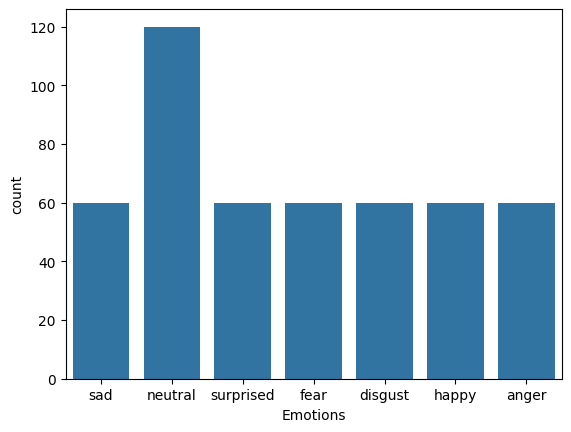

In [5]:
import seaborn as sns
sns.countplot(x='Emotions', data=savee_df)

Double the amount of neutral to make balanced only half of the neutral sounds will be used

In [6]:
len(savee_df)

480

In [7]:
for ang in range(len(savee_df)):
    if savee_df.loc[ang, 'Emotions']=='anger':
        print(ang)

61
65
84
103
117
119
131
132
152
153
157
163
166
167
183
192
203
204
217
232
235
257
258
262
286
287
292
293
319
324
326
332
333
338
354
356
366
368
370
371
381
382
393
394
403
404
405
406
415
416
427
438
439
440
449
457
465
466
475
476


In [8]:
savee_df.loc[52,'Path']

'JK_f07.wav'

In [9]:
print(savee_df.loc[10,'Emotions'])

sad


In [10]:
neutral_rows = savee_df[savee_df['Emotions'] == 'neutral']

neutrals = neutral_rows.sample(n=60)

savee_df = savee_df.drop(neutrals.index).reset_index(drop=True)

<Axes: xlabel='Emotions', ylabel='count'>

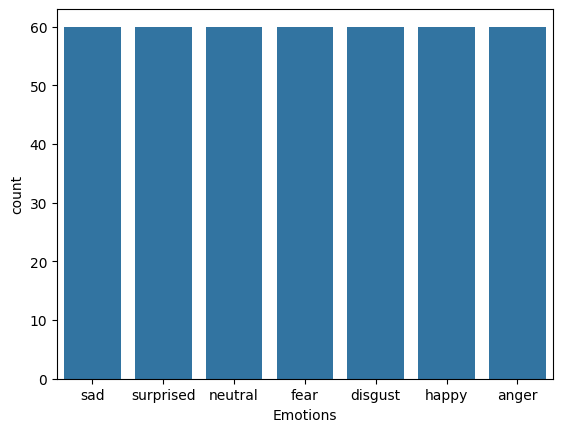

In [11]:
sns.countplot(x='Emotions', data=savee_df)

In [12]:
#Sad
sample_rate=None
data=None
def read_file(wav):
    global data
    global sample_rate
    file = os.path.join('ALL', wav)
    sample_rate, data = wavfile.read(file)
    
    
def play_file(sample_rate, data):
    sd.play(data, samplerate=sample_rate)

sad_wav=savee_df.loc[0, 'Path']
read_file(sad_wav)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/audioflux/display/display.py:179: UserWarning: Display after performing abs on complex numbers
  warnings.warn('Display after performing abs on complex numbers')


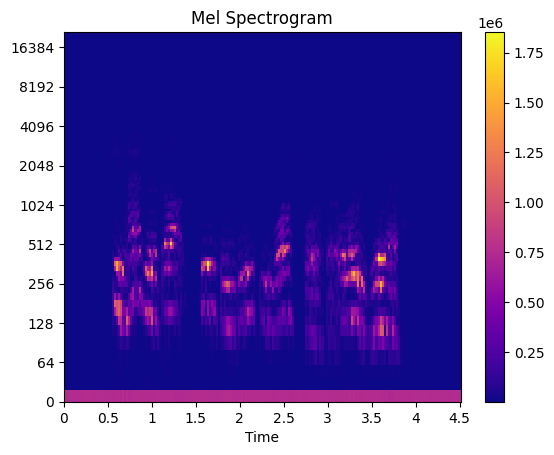

In [13]:
bft_obj = af.BFT(num=128, radix2_exp=12, samplate=sample_rate,
                scale_type=SpectralFilterBankScaleType.MEL)
spec_arr = bft_obj.bft(data)
fig,ax = plt.subplots()
img = fill_spec(spec_arr, axes=ax,
                x_coords=bft_obj.x_coords(data.shape[-1]),
                y_coords=bft_obj.y_coords(),
                x_axis='time', y_axis='log', title='Mel Spectrogram')
fig.colorbar(img)
plt.show()

In [14]:
print(spec_arr.dtype)

complex64


In [279]:
def graphs(sample_rate, data):
    # 3x2 grid
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))
    fig.tight_layout(pad=3.0)

    # General wave
    af.display.fill_wave(data, samplate=sample_rate, axes=axs[0, 0])

    # Mel Spectrogram
    bft_obj = af.BFT(num=128, radix2_exp=12, samplate=sample_rate,
                     scale_type=SpectralFilterBankScaleType.MEL)
    spec_arr = bft_obj.bft(data)
    img = fill_spec(spec_arr, axes=axs[0, 1],
                    x_coords=bft_obj.x_coords(data.shape[-1]),
                    y_coords=bft_obj.y_coords(),
                    x_axis='time', y_axis='log', title='Mel Spectrogram')
    fig.colorbar(img, ax=axs[0, 1])

    # MFCC
    bft_obj = af.BFT(num=128, radix2_exp=12, samplate=sample_rate,
                     scale_type=SpectralFilterBankScaleType.MEL,
                     data_type=SpectralDataType.POWER)
    spec_arr = bft_obj.bft(data)
    xxcc_obj = af.XXCC(bft_obj.num)
    xxcc_obj.set_time_length(time_length=spec_arr.shape[-1])
    mfcc_arr = xxcc_obj.xxcc(spec_arr)
    img = fill_spec(mfcc_arr, axes=axs[1, 0],
                    x_coords=bft_obj.x_coords(data.shape[-1]), x_axis='time', title='MFCC')
    fig.colorbar(img, ax=axs[1, 0])

    # CQT
    cqt_obj = af.CQT(num=84, samplate=sample_rate)
    cqt_arr = cqt_obj.cqt(data)
    img = fill_spec(cqt_arr, axes=axs[1, 1],
                    x_coords=cqt_obj.x_coords(data.shape[-1]),
                    y_coords=cqt_obj.y_coords(),
                    x_axis='time', y_axis='log', title='CQT')
    fig.colorbar(img, ax=axs[1, 1])

    # Chroma-CQT
    chroma_cqt_arr = cqt_obj.chroma(cqt_arr)
    img = fill_spec(chroma_cqt_arr, axes=axs[2, 0],
                    x_coords=cqt_obj.x_coords(data.shape[-1]),
                    x_axis='time', y_axis='chroma', title='Chroma-CQT')
    fig.colorbar(img, ax=axs[2, 0])

    # CWT
    cwt_obj = af.CWT(num=84, radix2_exp=12, samplate=sample_rate,
                     wavelet_type=WaveletContinueType.MORSE,
                     scale_type=SpectralFilterBankScaleType.OCTAVE)
    cwt_arr = np.abs(cwt_obj.cwt(data[..., :4096]))
    img = fill_spec(cwt_arr, axes=axs[2, 1],
                    x_coords=cwt_obj.x_coords(),
                    y_coords=cwt_obj.y_coords(),
                    x_axis='time', y_axis='log', title='CWT Spectrogram')
    fig.colorbar(img, ax=axs[2, 1])

    plt.show()


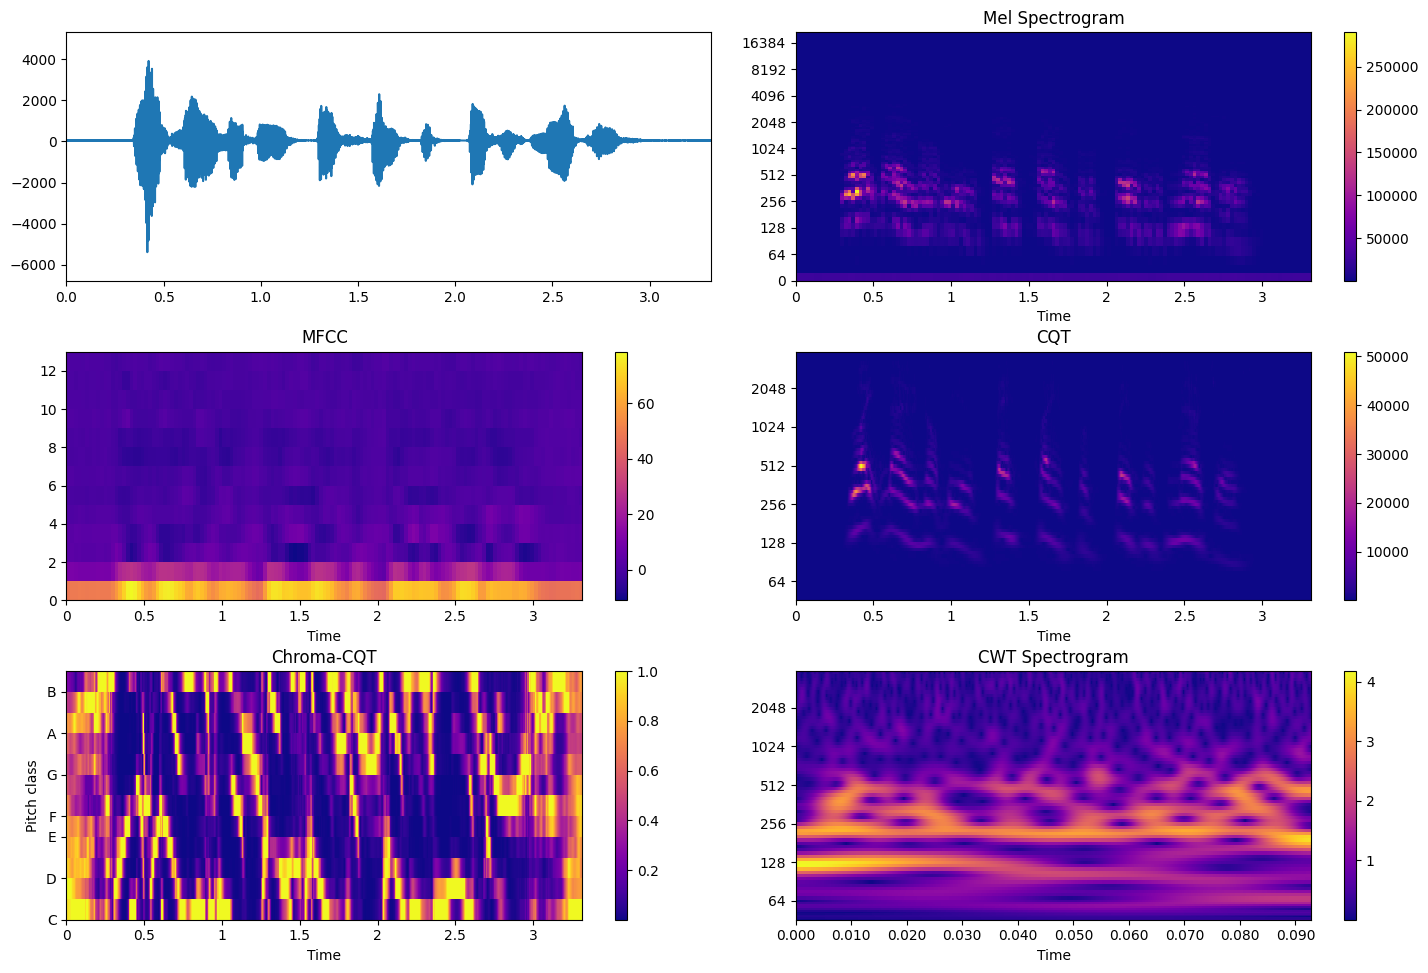

In [280]:
#Sad Emotion
graphs(sample_rate, data)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/audioflux/display/display.py:267: RuntimeWarning: overflow encountered in scalar subtract
  y_blank_len = np.abs(y_max - y_min) * y_blank_threshold


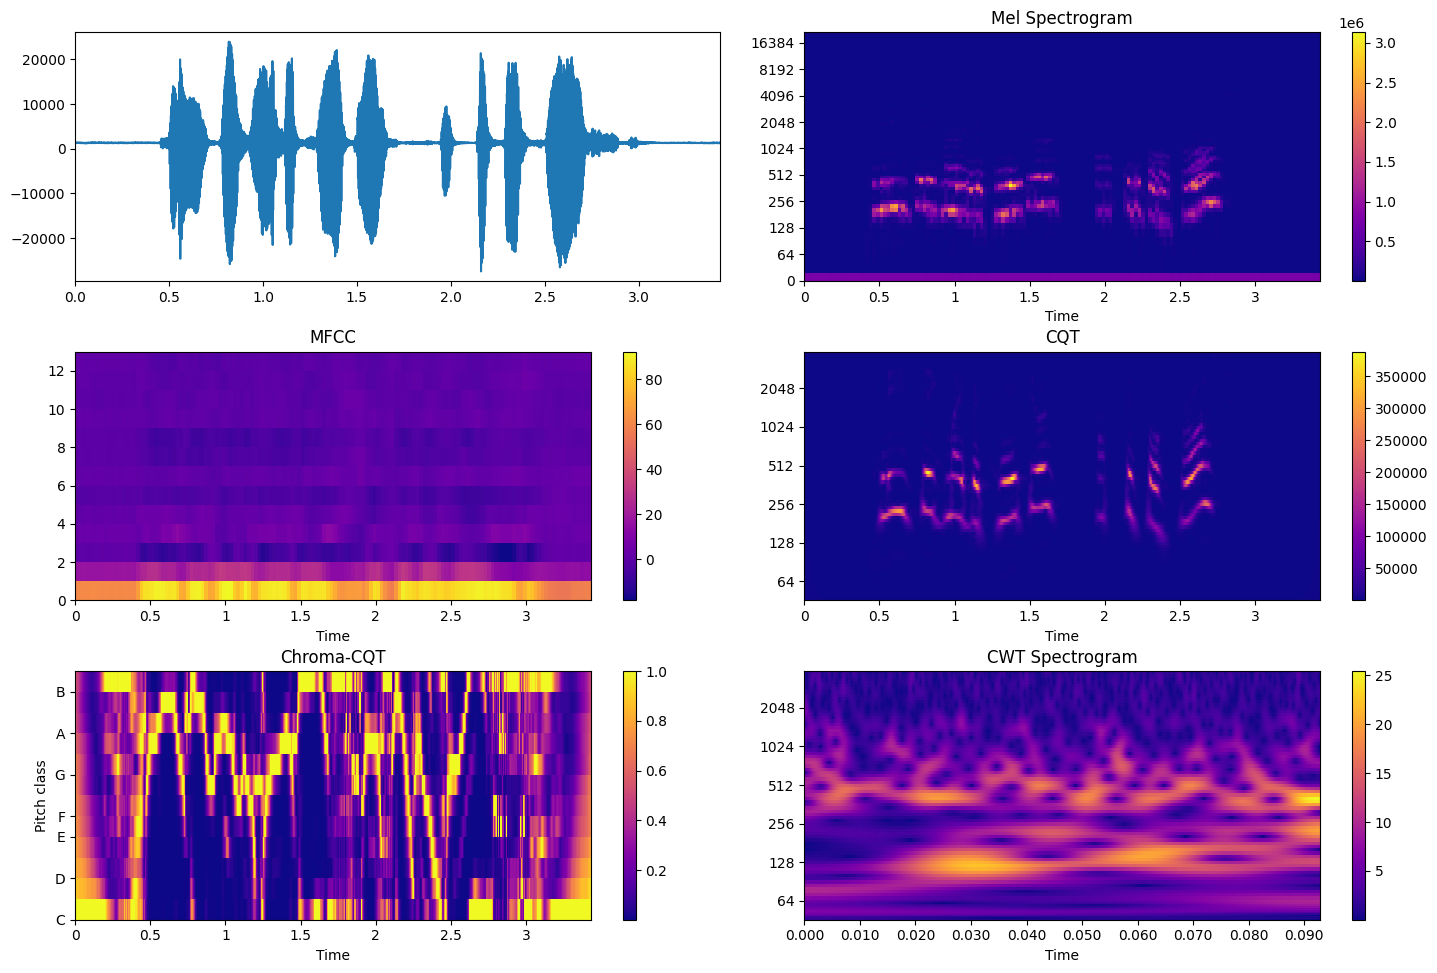

In [281]:
#Surprised Emotion
surprised_wav=savee_df.loc[3, 'Path']
read_file(surprised_wav)
graphs(sample_rate, data)

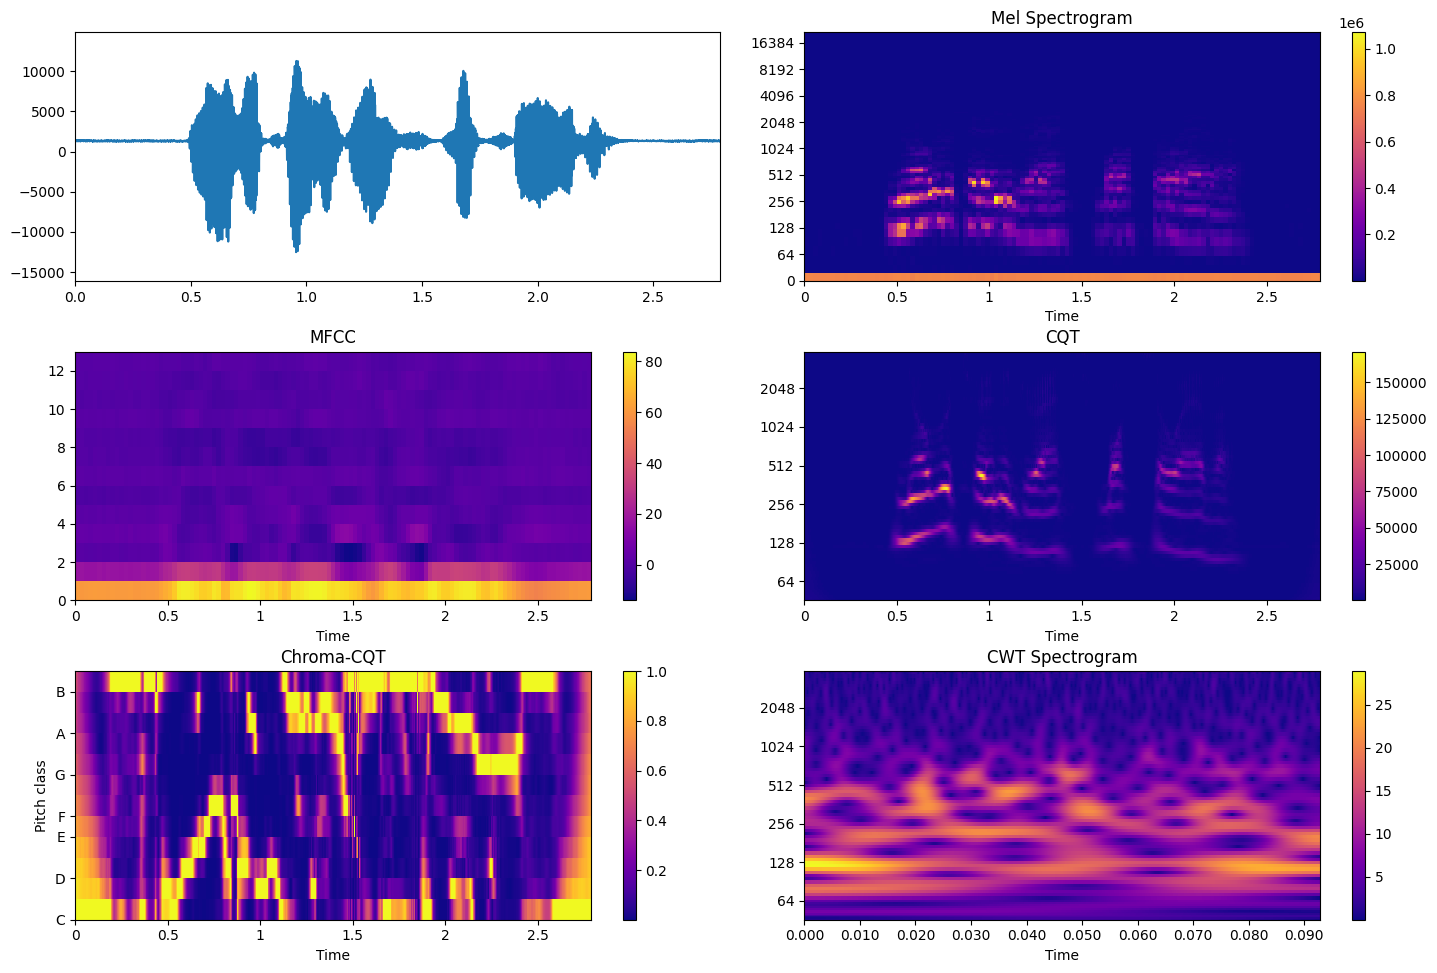

In [282]:
#Neutral Emotion
n_wav=savee_df.loc[2, 'Path']
read_file(n_wav)
graphs(sample_rate, data)

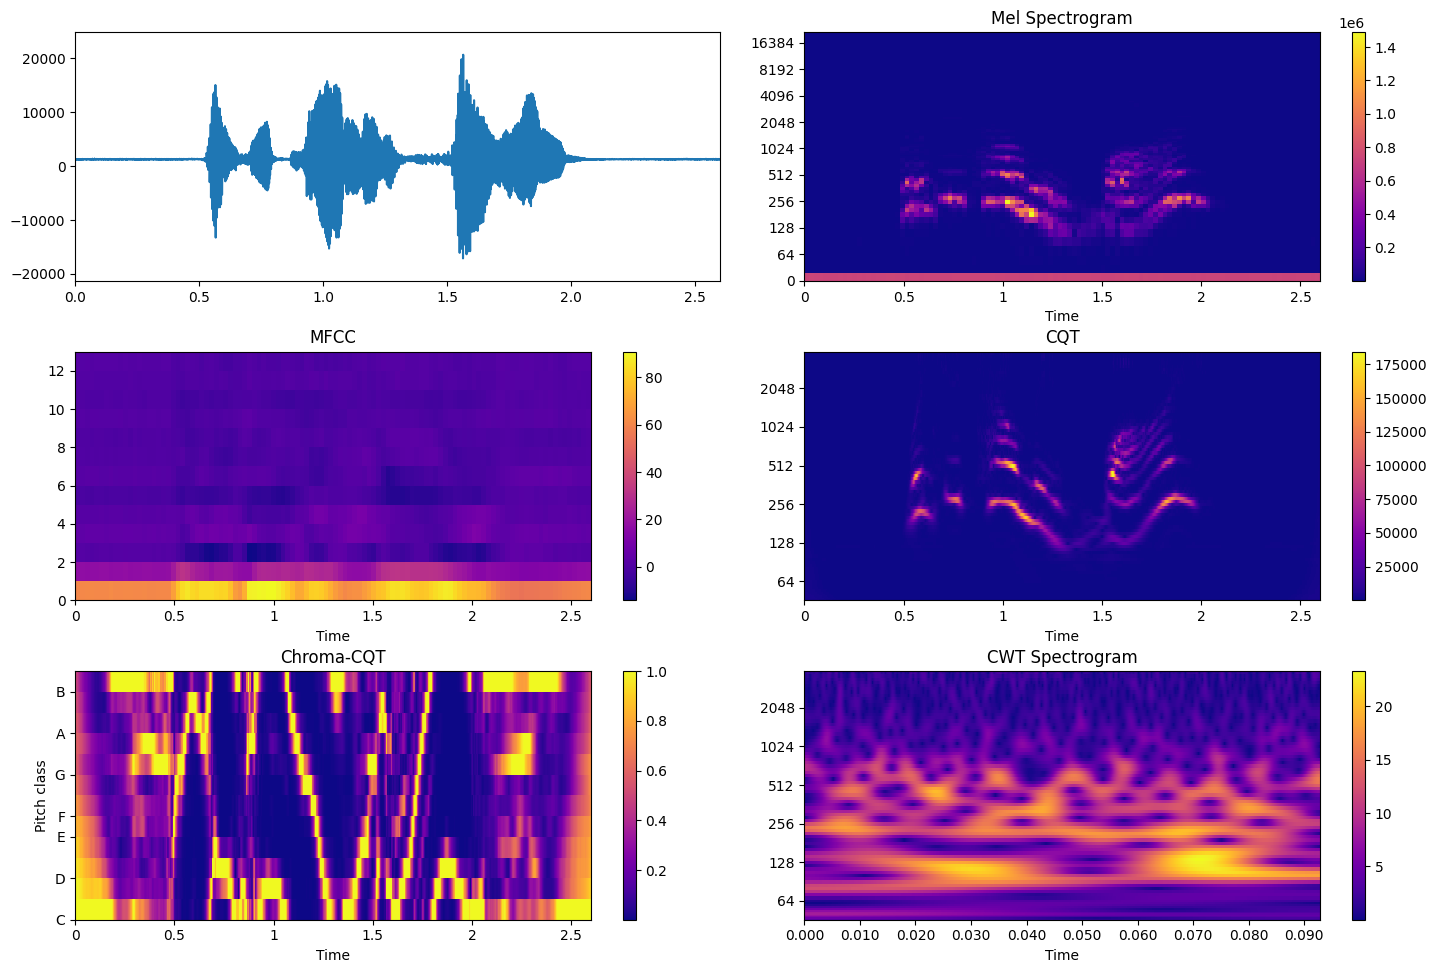

In [283]:
#Fear Emotion
fear_wav=savee_df.loc[9, 'Path']
read_file(fear_wav)
graphs(sample_rate, data)

In [284]:
cwts=[]
def turning_audio_to_CWT_Spectogram(savee_df):
    for wav in savee_df:
        file = os.path.join('ALL', wav)
        sample_rate, data = wavfile.read(file)
        cwt_obj = af.CWT(num=84, radix2_exp=12, samplate=sample_rate,
                     wavelet_type=WaveletContinueType.MORSE,
                     scale_type=SpectralFilterBankScaleType.OCTAVE)
        cwt_arr = np.abs(cwt_obj.cwt(data[..., :4096]))
        cwts.append(cwt_arr)

In [285]:
savee_df.loc[7]

Emotions            sad
Path        KL_sa13.wav
Name: 7, dtype: object

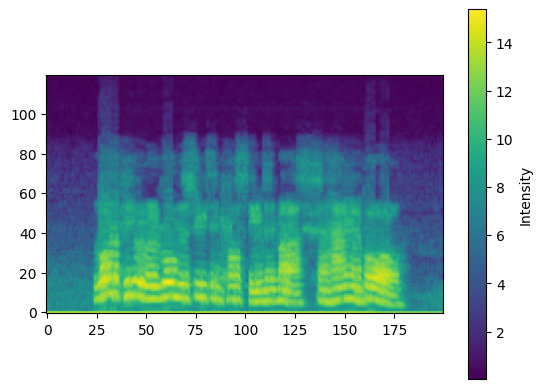

In [286]:
file = os.path.join('ALL', 'DC_a13.wav')
sample_rate, data = wavfile.read(file)

bft_obj = af.BFT(num=128, radix2_exp=12, samplate=sample_rate,
                scale_type=SpectralFilterBankScaleType.MEL)
spec_arr = bft_obj.bft(data)
spec_arr = np.abs(spec_arr)
fig,ax = plt.subplots()
spec_arr = cv2.resize(spec_arr, (200,120), interpolation=cv2.INTER_AREA)
processed_array = np.log1p(spec_arr)
'''img = fill_spec(spec_arr, axes=ax,
                x_coords=bft_obj.x_coords(data.shape[-1]),
                y_coords=bft_obj.y_coords(),
                x_axis='time', y_axis='log', title='Mel Spectrogram')'''
plt.imshow(processed_array, origin='lower')
plt.colorbar(label='Intensity')

In [16]:
!pip install librosa

  Using cached librosa-0.10.2.post1-py3-none-any.whl.metadata (8.6 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 3.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 7.0 MB/s eta 0:00:0000:0100:01


In [17]:
import librosa
import librosa.display

In [18]:
file = os.path.join('ALL', 'DC_a13.wav')
y, sr = librosa.load(file)

In [30]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

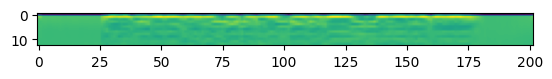

In [32]:
plt.imshow(mfccs)

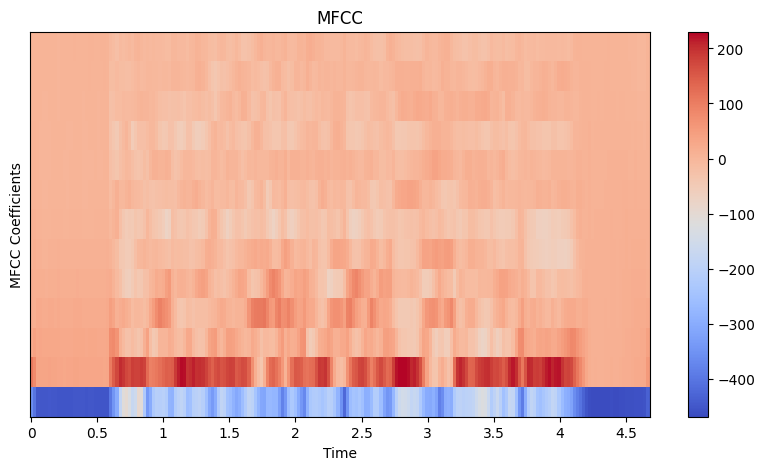

In [31]:
plt.figure(figsize=(10, 5))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.show()

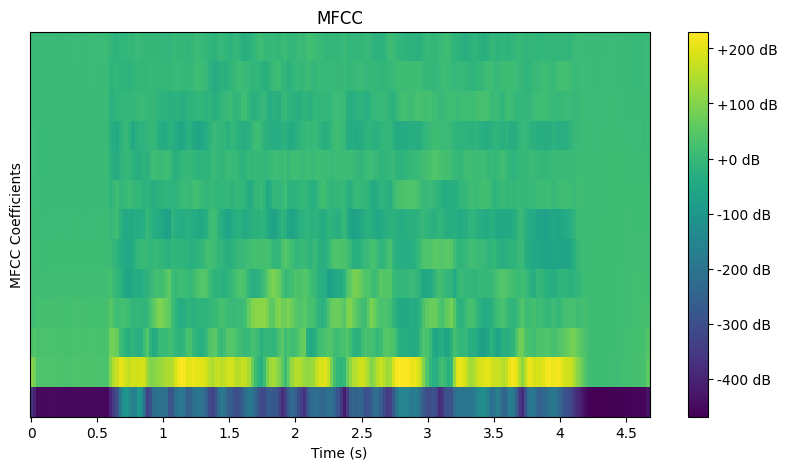

In [24]:
plt.figure(figsize=(10, 5))
librosa.display.specshow(mfccs, x_axis='time', cmap='viridis', hop_length=512)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients')
plt.show()

In [25]:
processed_array

NameError: name 'processed_array' is not defined

In [500]:
#Gabor Filter
#https://www.geeksforgeeks.org/opencv-getgaborkernel-method/ (Adapted from)
ksize = 32
sigma = 5/2 #i/2
angles = np.linspace(0, np.pi, 8, endpoint=False)  
frequency = 0.3
phase = 0

features=[]

for theta in angles: 
    kernel = cv2.getGaborKernel((ksize, ksize), 
                                    sigma, theta,
                                    frequency, phase) 
      
    filtered_image = cv2.filter2D(processed_array, cv2.CV_8UC3, kernel)
    features.append(filtered_image.flatten())

features = np.concatenate(features)
print("Feature vector length:", len(features))

Feature vector length: 192000


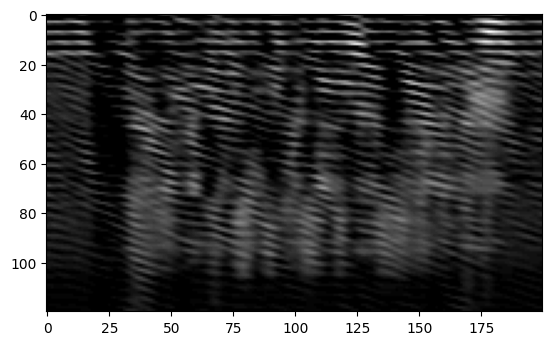

In [652]:
plt.imshow(filtered_image)

In [649]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 31.2 MB/s eta 0:00:00


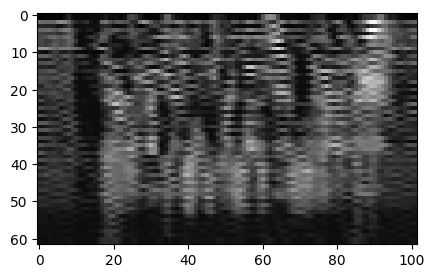

In [654]:
#https://pywavelets.readthedocs.io/en/latest/
import pywt
import pywt.data

# Load image
original = filtered_image

# Wavelet transform of image, and plot approximation and details
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))

plt.imshow(LL)

In [651]:
original

array([[200, 200, 200, ..., 189, 190, 190],
       [200, 199, 199, ..., 190, 190, 190],
       [199, 199, 199, ..., 190, 190, 190],
       ...,
       [ 25,  25,  27, ..., 139, 122, 147],
       [ 25,  25,  26, ..., 158, 141, 168],
       [ 25,  25,  27, ..., 151, 152, 149]], dtype=uint8)

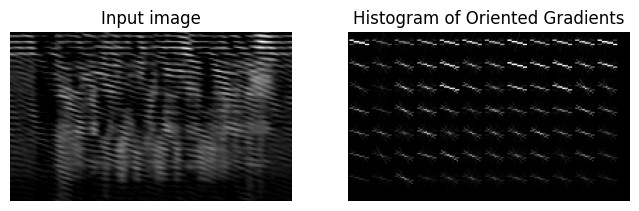

In [502]:
#https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html#references
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


image = filtered_image

fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=None,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [741]:
#With Gabor Filter implementation
import cv2

mel_spec=[]
def turning_mel(savee_df):
    try:
        for wav in savee_df:
            file = os.path.join(f'ALL/{wav}')
            sample_rate, data = wavfile.read(file)
            bft_obj = af.BFT(num=128, radix2_exp=12, samplate=sample_rate,
                         scale_type=SpectralFilterBankScaleType.MEL)
            spec_arr = bft_obj.bft(data)
            spec_arr = np.abs(spec_arr)
            spec_arr = np.log1p(spec_arr)
            image = cv2.resize(spec_arr, (200,120), interpolation=cv2.INTER_AREA)
            fd, hog_image = hog(image,
                                orientations=8,
                                pixels_per_cell=(16, 16),
                                cells_per_block=(1, 1),
                                visualize=True,
                                channel_axis=None)
            hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
            coeffs2 = pywt.dwt2(hog_image_rescaled, 'bior1.3')
            LL, (LH, HL, HH) = coeffs2
            mel_spec.append(LL)
    except Exception as e:
            print(f"Error processing file {wav}: {e}")

turning_mel(savee_df.loc[:, 'Path'])

In [629]:
import cv2

mfcc_spec=[]
def turning_mfcc(savee_df):
    try:
        for wav in savee_df:
            file = os.path.join(f'ALL/{wav}')
            sample_rate, data = wavfile.read(file)
            bft_obj = af.BFT(num=128, radix2_exp=12, samplate=sample_rate,
                     scale_type=SpectralFilterBankScaleType.MEL,
                     data_type=SpectralDataType.POWER)
            spec_arr = bft_obj.bft(data)
            xxcc_obj = af.XXCC(bft_obj.num)
            xxcc_obj.set_time_length(time_length=spec_arr.shape[-1])
            mfcc_arr = xxcc_obj.xxcc(spec_arr)
            mfcc_arr = np.abs(mfcc_arr)
            mfcc_arr = np.log1p(mfcc_arr)
            mfcc_arr = cv2.resize(mfcc_arr, (200,120), interpolation=cv2.INTER_AREA)
            for theta in angles: 
                kernel = cv2.getGaborKernel((ksize, ksize), 
                                            sigma, theta,
                                            frequency, phase) 
                filtered_image = cv2.filter2D(mfcc_arr, cv2.CV_8UC3, kernel)
            fd, hog_image = hog(filtered_image,
                                orientations=8,
                                pixels_per_cell=(16, 16),
                                cells_per_block=(1, 1),
                                visualize=True,
                                channel_axis=None)
            hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
            mfcc_spec.append(hog_image_rescaled)
    except Exception as e:
            print(f"Error processing file {wav}: {e}")

turning_mfcc(savee_df.loc[:, 'Path'])

In [700]:
import cv2

mfcc_spec=[]
def turning_mfcc(savee_df):
    try:
        for wav in savee_df:
            file = os.path.join(f'ALL/{wav}')
            sample_rate, data = wavfile.read(file)
            bft_obj = af.BFT(num=128, radix2_exp=12, samplate=sample_rate,
                     scale_type=SpectralFilterBankScaleType.MEL,
                     data_type=SpectralDataType.POWER)
            spec_arr = bft_obj.bft(data)
            xxcc_obj = af.XXCC(bft_obj.num)
            xxcc_obj.set_time_length(time_length=spec_arr.shape[-1])
            mfcc_arr = xxcc_obj.xxcc(spec_arr)
            mfcc_arr = np.abs(mfcc_arr)
            mfcc_arr = np.log1p(mfcc_arr)
            mfcc_arr = cv2.resize(mfcc_arr, (200,120), interpolation=cv2.INTER_AREA)
            for theta in angles: 
                kernel = cv2.getGaborKernel((ksize, ksize), 
                                            sigma, theta,
                                            frequency, phase) 
                filtered_image = cv2.filter2D(mfcc_arr, cv2.CV_8UC3, kernel)
            fd, hog_image = hog(filtered_image,
                                orientations=8,
                                pixels_per_cell=(16, 16),
                                cells_per_block=(1, 1),
                                visualize=True,
                                channel_axis=None)
            hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
            coeffs2 = pywt.dwt2(hog_image_rescaled, 'bior1.3')
            LL, (LH, HL, HH) = coeffs2
            mfcc_spec.append(LL)
    except Exception as e:
            print(f"Error processing file {wav}: {e}")

turning_mfcc(savee_df.loc[:, 'Path'])

In [656]:
#data.shape[-1]/sample_rate

In [416]:
#With HOG Implementation
import cv2

mel_spec=[]
def turning_mel(savee_df):
    try:
        for wav in savee_df:
            file = os.path.join(f'ALL/{wav}')
            sample_rate, data = wavfile.read(file)
            bft_obj = af.BFT(num=128, radix2_exp=12, samplate=sample_rate,
                         scale_type=SpectralFilterBankScaleType.MEL)
            spec_arr = bft_obj.bft(data)
            spec_arr = np.abs(spec_arr)
            spec_arr = np.log1p(spec_arr)
            image = cv2.resize(spec_arr, (200,120), interpolation=cv2.INTER_AREA)
            for theta in angles: 
                kernel = cv2.getGaborKernel((ksize, ksize), 
                                            sigma, theta,
                                            frequency, phase) 
                filtered_image = cv2.filter2D(image, cv2.CV_8UC3, kernel)
            fd, hog_image = hog(filtered_image,
                                orientations=8,
                                pixels_per_cell=(16, 16),
                                cells_per_block=(1, 1),
                                visualize=True,
                                channel_axis=None)
            hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
            mel_spec.append(hog_image_rescaled)
    except Exception as e:
            print(f"Error processing file {wav}: {e}")

turning_mel(savee_df.loc[:, 'Path'])

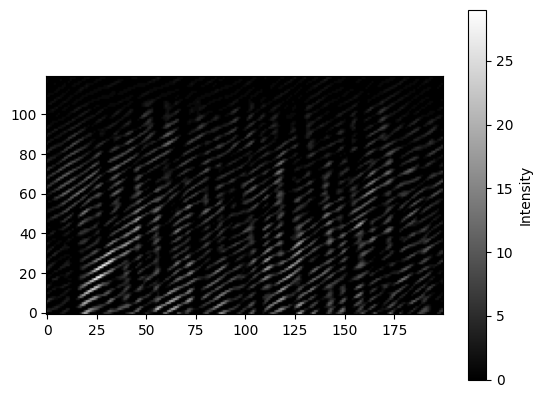

In [393]:
plt.imshow(mel_spec[1], origin='lower')
plt.colorbar(label='Intensity')

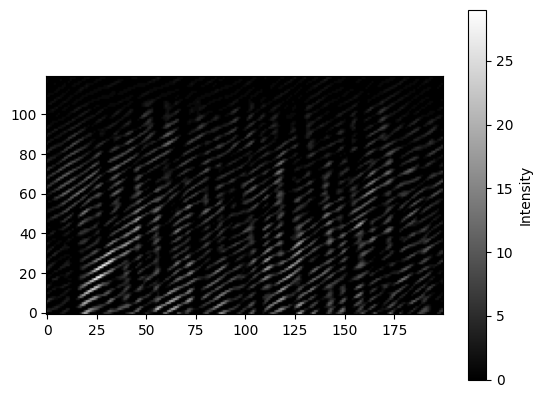

In [394]:
plt.imshow(mel_spec[1], origin='lower')
plt.colorbar(label='Intensity')

In [33]:
y= savee_df.loc[:, 'Emotions']

In [34]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(['sad', 'fear', 'anger', 'disgust', 'neutral', 'surprised', 'happy'])
y_transformed=le.transform(y)

NOTE : It has marked:

0 - Anger 

1 - Disgust

2 - Fear

3 - Happy

4 - Neutral

5 - Sad

6 - Surprised

In [35]:
y

0            sad
1            sad
2      surprised
3        neutral
4            sad
         ...    
415        anger
416        anger
417      neutral
418    surprised
419    surprised
Name: Emotions, Length: 420, dtype: object

In [36]:
y_transformed

array([5, 5, 6, 4, 5, 2, 2, 5, 5, 1, 3, 3, 3, 1, 5, 5, 2, 5, 4, 4, 6, 5,
       5, 4, 4, 2, 5, 5, 1, 3, 3, 1, 5, 1, 5, 2, 4, 5, 5, 5, 4, 4, 2, 2,
       3, 5, 1, 5, 1, 2, 3, 0, 3, 3, 3, 0, 2, 1, 5, 1, 3, 2, 2, 4, 4, 5,
       5, 5, 5, 4, 4, 0, 2, 2, 1, 1, 5, 1, 3, 3, 3, 3, 1, 5, 1, 1, 2, 2,
       4, 0, 4, 5, 5, 4, 6, 6, 3, 3, 2, 4, 0, 0, 1, 5, 5, 3, 3, 3, 3, 5,
       5, 1, 0, 0, 2, 3, 3, 6, 6, 4, 6, 6, 1, 3, 6, 3, 4, 4, 0, 0, 5, 5,
       3, 0, 3, 2, 2, 3, 3, 0, 5, 5, 0, 0, 4, 6, 3, 3, 1, 4, 6, 6, 6, 4,
       3, 0, 4, 5, 3, 3, 5, 4, 0, 3, 3, 6, 6, 6, 4, 3, 0, 0, 4, 6, 4, 5,
       3, 3, 3, 5, 5, 6, 0, 3, 6, 1, 6, 2, 4, 6, 4, 6, 1, 1, 0, 2, 2, 0,
       1, 6, 6, 4, 2, 2, 6, 1, 4, 4, 1, 1, 6, 6, 2, 4, 6, 6, 1, 0, 0, 2,
       2, 2, 0, 1, 6, 6, 2, 6, 1, 4, 4, 4, 1, 1, 6, 3, 6, 2, 2, 6, 1, 1,
       0, 0, 2, 2, 2, 2, 0, 0, 1, 1, 4, 6, 2, 2, 3, 6, 6, 1, 1, 4, 4, 6,
       1, 1, 6, 6, 2, 2, 4, 6, 6, 4, 0, 4, 1, 1, 5, 0, 3, 0, 2, 2, 2, 2,
       3, 0, 0, 5, 1, 1, 4, 0, 6, 2, 2, 6, 6, 1, 1,

In [526]:
#list(le.inverse_transform(y))

In [722]:
mfcc_spec[0].shape #ALL DIFFERENT SIZES NEED TO BE THE SAME

(62, 102)

In [528]:
mel_spec[1].shape

(120, 200)

In [742]:
X = np.array(mel_spec)

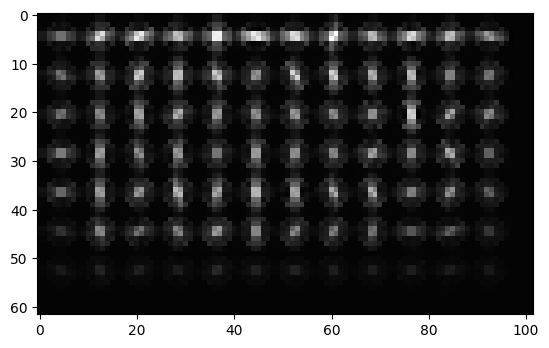

In [743]:
plt.imshow(X[0])

In [744]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.4, random_state=42)

In [745]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [746]:
X_train.shape

(252, 62, 102)

In [747]:
X_test.shape

(84, 62, 102)

In [748]:
X_reshaped = X_train.reshape(252, 62*102)
X_val_reshaped = X_val.reshape(84, 62*102)
X_test_reshaped = X_test.reshape(84, 62*102)

In [749]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

k_list = []
scores_list = [] 
 
for k in range(1,100):
        knn = KNeighborsClassifier(n_neighbors=k, weights="distance", metric="euclidean")
        knn.fit(X_reshaped,y_train)
        y_pred=knn.predict(np.array(X_test_reshaped)) 
        k_list.append(k)
        accuracy = metrics.accuracy_score(y_test,y_pred)
        print(k, 'accuracy',accuracy)
        scores_list.append(metrics.accuracy_score(y_test,y_pred))

1 accuracy 0.2857142857142857
2 accuracy 0.2857142857142857
3 accuracy 0.30952380952380953
4 accuracy 0.2619047619047619
5 accuracy 0.36904761904761907
6 accuracy 0.34523809523809523
7 accuracy 0.34523809523809523
8 accuracy 0.36904761904761907
9 accuracy 0.3333333333333333
10 accuracy 0.39285714285714285
11 accuracy 0.40476190476190477
12 accuracy 0.38095238095238093
13 accuracy 0.38095238095238093
14 accuracy 0.39285714285714285
15 accuracy 0.35714285714285715
16 accuracy 0.36904761904761907
17 accuracy 0.36904761904761907
18 accuracy 0.35714285714285715
19 accuracy 0.35714285714285715
20 accuracy 0.38095238095238093
21 accuracy 0.36904761904761907
22 accuracy 0.39285714285714285
23 accuracy 0.38095238095238093
24 accuracy 0.38095238095238093
25 accuracy 0.36904761904761907
26 accuracy 0.32142857142857145
27 accuracy 0.32142857142857145
28 accuracy 0.32142857142857145
29 accuracy 0.35714285714285715
30 accuracy 0.34523809523809523
31 accuracy 0.30952380952380953
32 accuracy 0.3095238

In [750]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score

dtc = DecisionTreeClassifier(criterion = 'entropy', max_depth=3)
dtc.fit(X_reshaped, y_train)
y_pred = dtc.predict(X_test_reshaped)
print(accuracy_score(y_test, y_pred))

0.23809523809523808


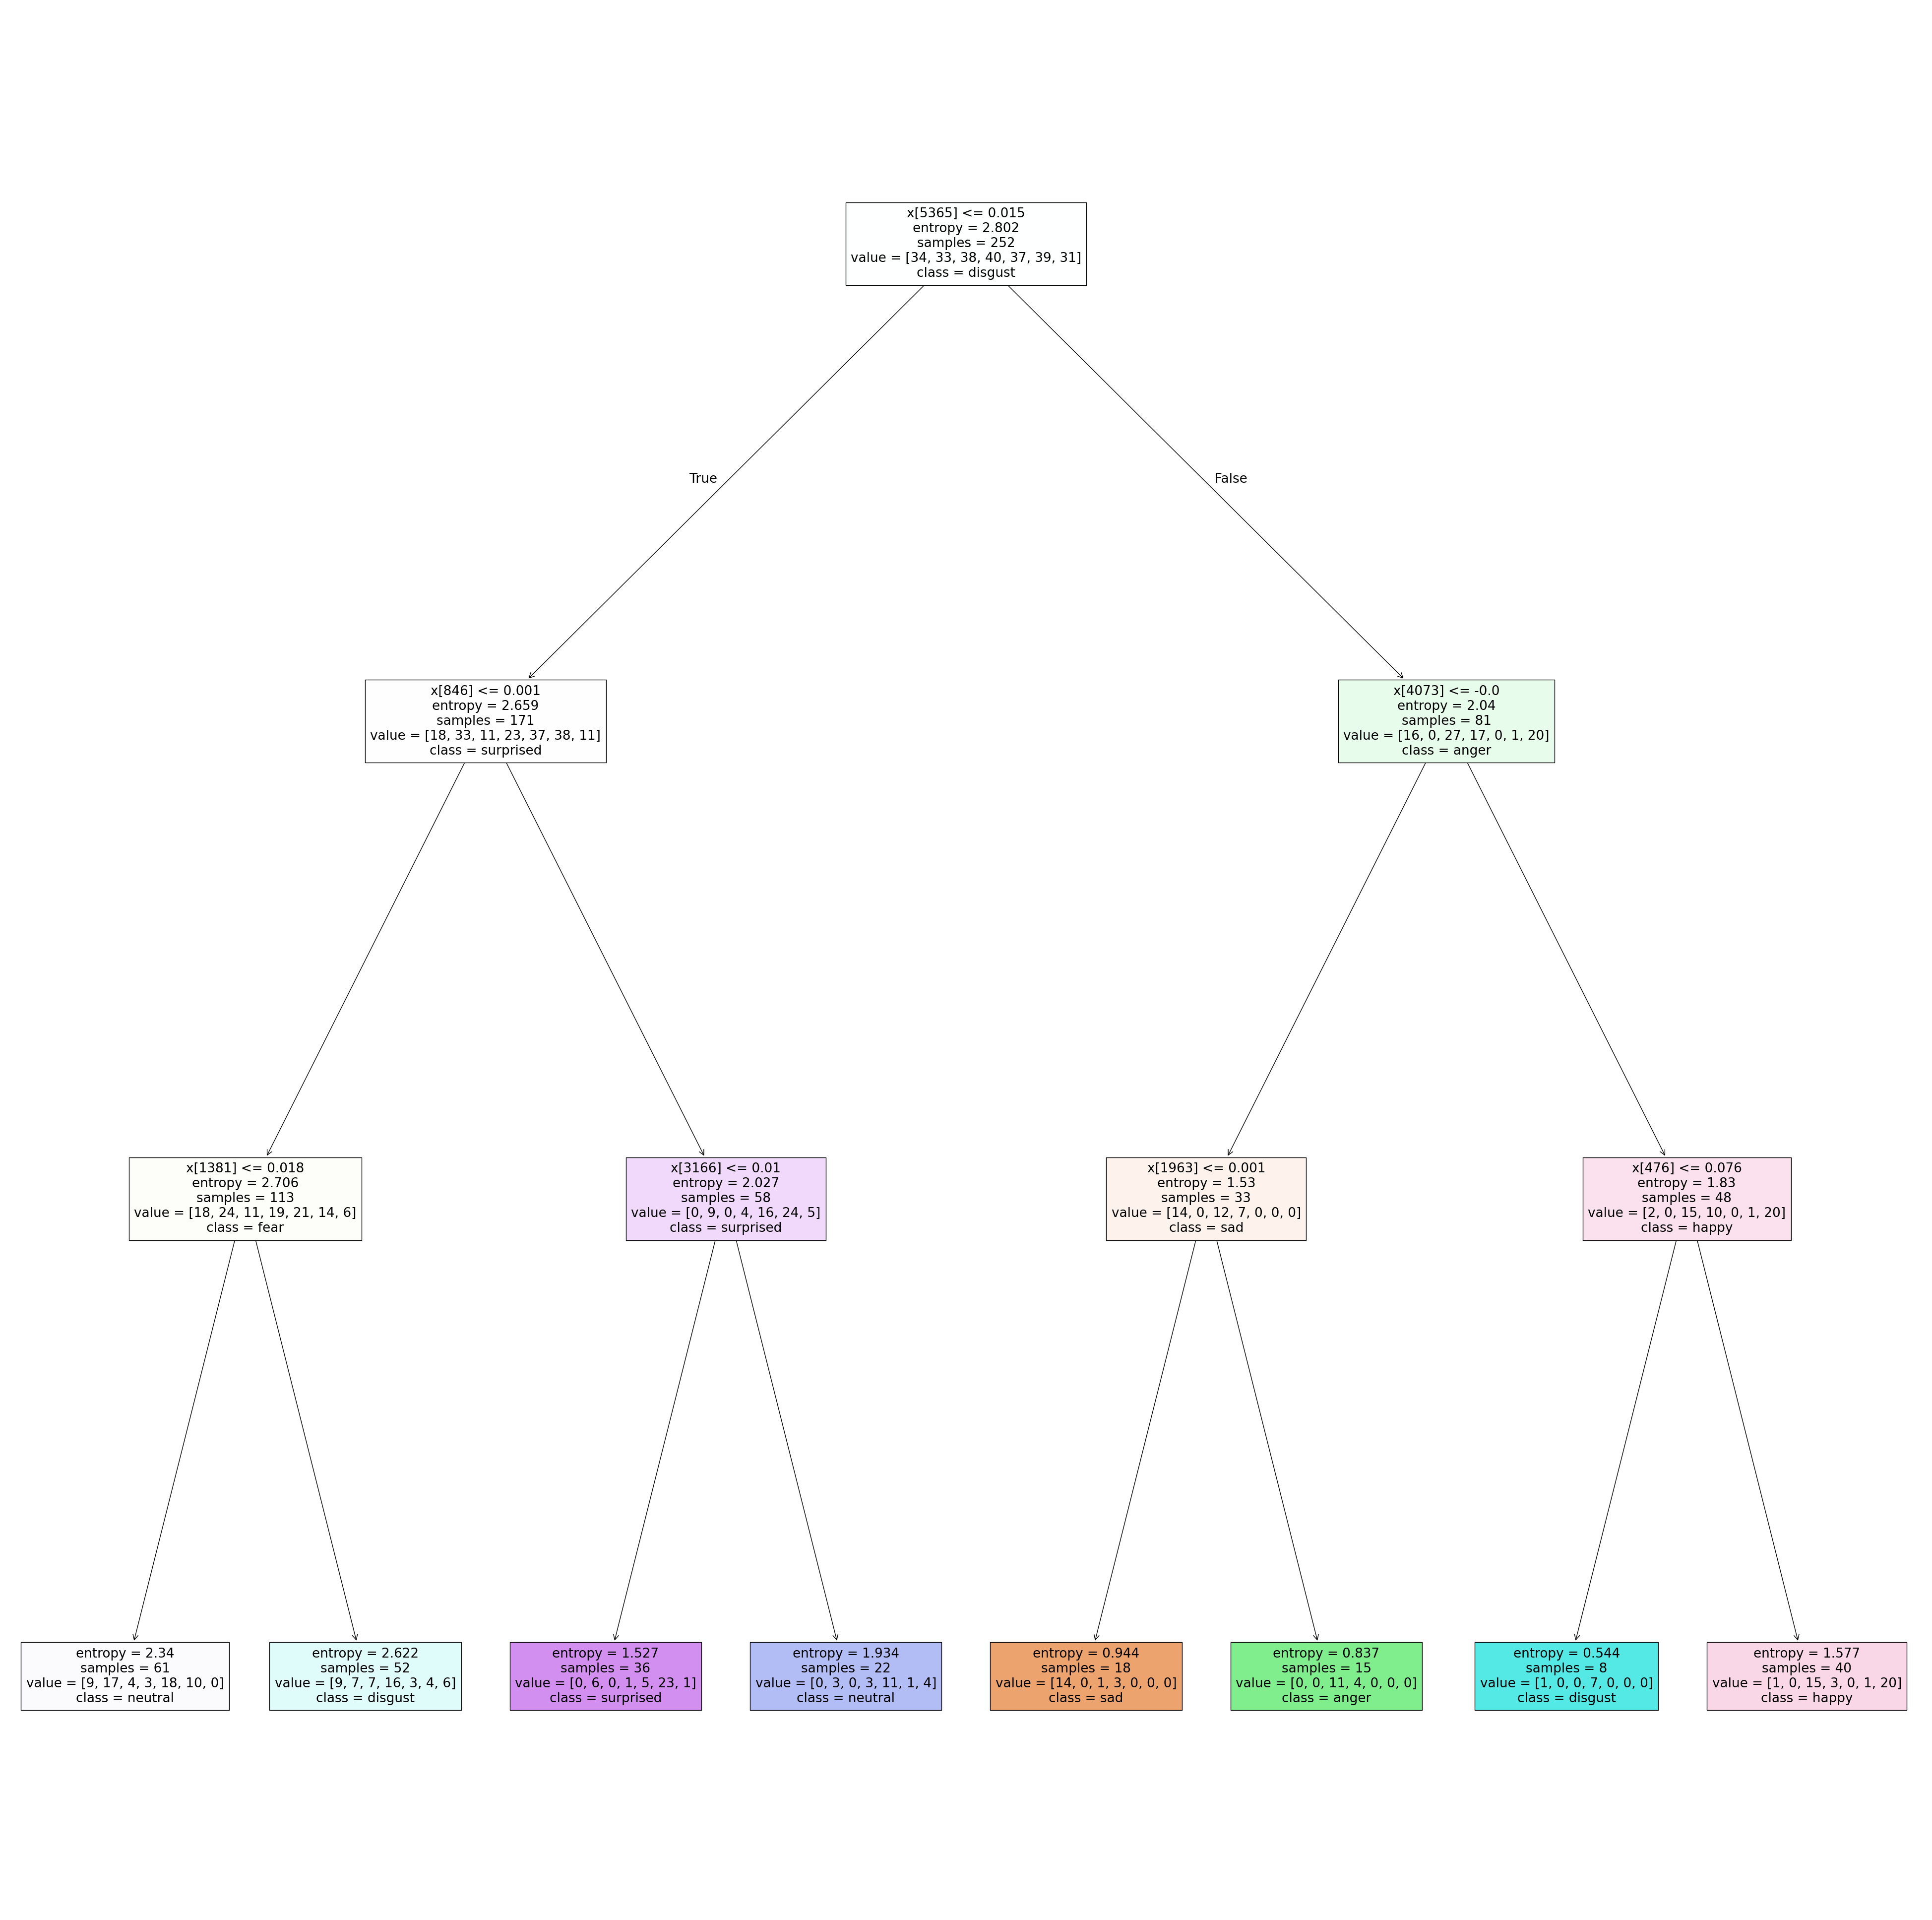

In [751]:
plt.figure(figsize=(50,50))
_ = tree.plot_tree(dtc, class_names=['sad', 'fear', 'anger', 'disgust', 'neutral', 'surprised', 'happy'], filled=True)

In [752]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_reshaped, y_train)
y_pred = rfc.predict(X_test_reshaped)
print(accuracy_score(y_test, y_pred))

0.38095238095238093


In [734]:
X_train[0].shape

(62, 102)

In [735]:
import tensorflow

In [754]:
# model from https://medium.com/@sanjay_dutta/designing-your-own-convolutional-neural-network-cnn-model-a-step-by-step-guide-for-beginners-4e8b57836c81
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(62, 102, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [755]:
history = model.fit(X_train,y_train,
                    epochs=30,
                    validation_data=(X_val,y_val))

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.1273 - loss: 2.2143 - val_accuracy: 0.2143 - val_loss: 2.0754
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.2017 - loss: 2.0652 - val_accuracy: 0.1190 - val_loss: 2.0366
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.1576 - loss: 2.0276 - val_accuracy: 0.1190 - val_loss: 2.0079
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.1527 - loss: 1.9977 - val_accuracy: 0.2381 - val_loss: 1.9977
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.1869 - loss: 2.0230 - val_accuracy: 0.2024 - val_loss: 1.9860
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.1232 - loss: 2.0215 - val_accuracy: 0.1786 - val_loss: 1.9723
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.1620 - loss: 1.9850 - val_accuracy: 0.1548 - val_loss: 1.9640
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.2154 - loss: 1.9639 - val_accuracy: 0.2024 - val_loss: 1.9068


In [756]:
model.evaluate(X_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3385 - loss: 1.8734


[1.9539010524749756, 0.3333333432674408]

https://www.sciencedirect.com/science/article/pii/S0003682X18300409
Try following the work of what they have done here

In [757]:
from sklearn import svm

model=svm.SVC()
model.fit(X_reshaped,y_train)

SVC()

In [758]:
y_pred = model.predict(X_test_reshaped)
print(accuracy_score(y_test, y_pred))

0.2857142857142857


## 